In [163]:
import pandas as pd
import numpy as np
from random import randint
import random
import time
import re
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Web-app visualizations
import plotly.express as px

# Data wrangling

In [3]:
df = pd.read_csv("data_tables/centris_montreal_complete.csv")

In [4]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Data columns (total 101 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               5732 non-null   int64  
 1   title                                    5732 non-null   object 
 2   address                                  5732 non-null   object 
 3   price                                    5732 non-null   object 
 4   lat                                      5732 non-null   float64
 5   long                                     5732 non-null   float64
 6   Restaurants                              5724 non-null   float64
 7   Shopping                                 5726 non-null   float64
 8   Vibrant                                  5724 non-null   float64
 9   Cycling friendly                         5723 non-null   float64
 10  Car friendly                             5721 n

We first remove the last 5 columns since they have virtually no content

In [5]:
df = df.loc[:,:"bedroom in basement"]

Next we will change the data type of the price column to integer

In [6]:
price_clean = df.price.str.replace("[$,]", "")
df.price = price_clean.astype("int")
df.price.describe()

count    5.732000e+03
mean     7.634336e+05
std      8.866054e+05
min      5.000000e+03
25%      3.999000e+05
50%      5.590000e+05
75%      8.242250e+05
max      2.780000e+07
Name: price, dtype: float64

## Duplicate data

We will use the `address` column to check for duplications.

In [7]:
df.address.duplicated().sum()

308

In [8]:
df = df[df.address.duplicated() == False]
df.reset_index(inplace=True)
df.info(max_cols=95)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Columns: 97 entries, index to bedroom in basement
dtypes: float64(32), int64(41), object(24)
memory usage: 4.0+ MB


Removing duplicates leaves holes in the index. Due to `reset_index()`, the range now coincides with the number of entries. 
The first two columns, corresponding to copies of the old and new index, can be removed.

In [9]:
df = df.loc[:, "title":]
df.columns

Index(['title', 'address', 'price', 'lat', 'long', 'Restaurants', 'Shopping',
       'Vibrant', 'Cycling friendly', 'Car friendly', 'Historic', 'Quiet',
       'Elementary Schools', 'High Schools', 'Parks', 'Nightlife', 'Groceries',
       'Daycares', 'Pedestrian friendly', 'Cafes', 'Transit friendly',
       'Greenery', 'rooms', 'bedrooms', 'bathroom', 'Condominium type',
       'Net area', 'Year built', 'Parking (total)', 'Population 2016 ',
       'Population variation between 2011 2016 ', 'Population density ',
       'Unemployment rate 2016 ', 'Less than $50,000 (%)',
       'Between $50,000 and $80,000 (%)', 'Between $80,000 and $100,000 (%)',
       'Between $100,000 and $150,000 (%)', 'More than $150,000 (%)',
       '1-person households (%)', '2-person households (%)',
       '3-person households (%)', '4-person households (%)',
       '5-person or more households (%)',
       'Couples without children at home (%)',
       'Couples with children at home (%)', 'Single-parent fa

## Room columns

There are two columns called `rooms` and `room`. We will inspect both to find an explenation for this.

In [10]:
df[df.room.notnull()].loc[:,["address", "room", "rooms"]].head()

,address,room,rooms
32,"4225, Rue Saint-Dominique, apt. 209, Montréal ...",1.0,NaN
95,"318Z - 330Z, Rue Sherbrooke Est, Montréal (Vil...",1.0,NaN
109,"1188, Rue Saint-Antoine Ouest, apt. P3-16-17, ...",1.0,NaN
142,"1000, Rue Ottawa, apt. 606, Montréal (Le Sud-O...",1.0,NaN
283,"6541, boulevard Saint-Laurent, apt. 201, Montr...",1.0,NaN


The room column corresponds to listings with with only a single room. This has been verified by visting the website and searching for some of the addresses. We will therefore merge the two columns.

In [11]:

print("Non-null values in 'rooms':")
print("Before merge -", df.rooms.notnull().sum())
# Merging "rooms" and "room"
rooms_new = pd.Series(\
    [room if pd.notna(room) else rooms for room, rooms in zip(df.room, df.rooms)]\
        )
# Remove old columns
df.drop(["rooms", "room"], axis=1, inplace=True)
# Add new column
df["rooms"] = rooms_new
print("After merge -", df.rooms.notnull().sum())

Non-null values in 'rooms':
Before merge - 4421
After merge - 4451


We will now incpect other columns that contain the string "room" and replace missing values by 0 to facilitate mathematical operations on room data. 

In [12]:
rooms = df.columns[["room" in col for col in df.columns]]
df[rooms] = df[rooms].fillna(0)
print(df[rooms].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              5424 non-null   float64
 1   bathroom              5424 non-null   float64
 2   bathrooms             5424 non-null   float64
 3   bedroom               5424 non-null   float64
 4   powder room           5424 non-null   float64
 5   powder rooms          5424 non-null   float64
 6   bedrooms in basement  5424 non-null   float64
 7   bedroom in basement   5424 non-null   float64
 8   rooms                 5424 non-null   float64
dtypes: float64(9)
memory usage: 381.5 KB
None


In [13]:
# Grouping similar columns
bedroom_cols = ['bedrooms','bedroom','bedrooms in basement', 'bedroom in basement']
bathroom_cols = ['bathroom', 'bathrooms']
powederroom_cols = ['powder room', 'powder rooms']

## Bedrooms

In [14]:
df[bedroom_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bedrooms              5424 non-null   float64
 1   bedroom               5424 non-null   float64
 2   bedrooms in basement  5424 non-null   float64
 3   bedroom in basement   5424 non-null   float64
dtypes: float64(4)
memory usage: 169.6 KB


First, we merge `bedrooms` and `bedroom` since they clearly belong together

In [15]:
# Replace missing values with 0 for element-wise addition
bedrooms = df.bedrooms.fillna(0) + df.bedroom.fillna(0)
# Drop old columns from df
df.drop(["bedrooms", "bedroom"], axis=1)
# Add new column
df.bedrooms = bedrooms

In [16]:
# At least 1 bedroom in basement
df[df["bedrooms in basement"] > 0].\
    loc[:, ["address", "bedrooms", "bedrooms in basement", "bedroom in basement", "price"]].head()

,address,bedrooms,bedrooms in basement,bedroom in basement,price
151,"61A, Avenue Strathyre, Montréal (LaSalle)",0.0,2.0,0.0,259000
273,"1300, Rue Jarry Est, apt. 1, Montréal (Villera...",0.0,2.0,0.0,259000
353,"2061, Rue Beaudry, Montréal (Ville-Marie), Nei...",0.0,2.0,0.0,419000
627,"4723, Rue Ontario Est, apt. 102, Montréal (Mer...",0.0,2.0,0.0,259000
670,"7940, Rue Chabot, apt. 102, Montréal (Villeray...",0.0,2.0,0.0,379000


Bedrooms in the basement may be worth less, merging them with regular bedrooms may therefore not be optimal. However, the listings with bedrooms in the basement don't have regular bedrooms. This is true for for the entire list as well as for listings with a single bedroom in the basement. Merging all columns, therefore, appears to be the best solution. To keep a record of basement bedrooms, we will include a boolean column that can be used to either remove or alter corresponding entries at a later point.

In [17]:
def not_zero(col):
    """Returns boolean list indicating records with counts of at least 1"""

    not_zero = [count > 0 for count in col]
    return not_zero

In [18]:
# Merge of basement bedroom columns
basement_bed = df["bedrooms in basement"]\
         + df["bedroom in basement"]

# Records with basement bedrooms
basement_bed_bool = not_zero(basement_bed)
print("Apartments with basement bedrooms:",\
    sum(basement_bed_bool))

# Merge of basement with regular bedrooms
all_bedrooms = basement_bed + df.bedrooms
print("Apartments with any kind of bedroom",\
    sum(not_zero(all_bedrooms)))

Apartments with basement bedrooms: 75
Apartments with any kind of bedroom 4402


In [19]:
# Remove old columns 
df.drop(bedroom_cols, axis=1, inplace=True)

# Append new columns
df["bedrooms"] = all_bedrooms
df["basement_bedroom"] = basement_bed_bool

## Bathrooms

In [20]:
# Non-zero records
df[bathroom_cols].apply(lambda col: sum(not_zero(col)), axis=0)

bathroom     2465
bathrooms    1967
dtype: int64

In [21]:
# Merge
bathrooms = df.bathroom + df.bathrooms
print("Non-zero records of merged column:", sum(not_zero(bathrooms)))

# Remove old columns 
df.drop(bathroom_cols, axis=1, inplace=True)

# Append new column
df["bathrooms"] = bathrooms

Non-zero records of merged column: 4432


In [22]:
df.iloc[:, -4:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424 entries, 0 to 5423
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rooms             5424 non-null   float64
 1   bedrooms          5424 non-null   float64
 2   basement_bedroom  5424 non-null   bool   
 3   bathrooms         5424 non-null   float64
dtypes: bool(1), float64(3)
memory usage: 132.5 KB


## Powder rooms

In [23]:
# Non-zero records
df[powederroom_cols].apply(lambda col: sum(not_zero(col)))

powder room     1086
powder rooms      81
dtype: int64

In [24]:
# Merge
powder_rooms = df['powder room'] + df['powder rooms']

# Remove old 
df.drop(powederroom_cols, axis=1, inplace=True)

# Append new
df['powder_rooms'] = powder_rooms

In [25]:
# New room data
room_data = df.iloc[:, [-5,-4,-2,-1]]

print("Non-zero records:")
room_data.apply(lambda col: sum(not_zero(col)))

Non-zero records:


rooms           4451
bedrooms        4402
bathrooms       4432
powder_rooms    1167
dtype: int64

## Missing Room Data

Next we will inspect records with missing data for all 4 room columns

In [26]:
# Records with 0 for all room features
# "not any(not_zero(rows))" is True, only if all records in a row are zero
missing_room_data = df[room_data.apply(lambda rows: (not any(not_zero(rows))), axis=1)]

print("Number of records with missing room data:", \
    missing_room_data.shape[0])
print("Number of replacable missing room data:", \
    missing_room_data.loc[:, "Main unit"].notnull().sum())

missing_room_data.iloc[:,[0, 1, 2,-5,-4,-2, -1]].head()

Number of records with missing room data: 973
Number of replacable missing room data: 868


,title,address,price,rooms,bedrooms,bathrooms,powder_rooms
9,Duplex for sale,"5421 - 5423, 15e Avenue, Montréal (Rosemont/La...",679000,0.0,0.0,0.0,0.0
10,Quadruplex for sale,"9636 - 9640, Rue Notre-Dame Est, Montréal (Mer...",569750,0.0,0.0,0.0,0.0
25,Duplex for sale,"1915 - 1917, Rue Viau, Montréal (Mercier/Hoche...",899000,0.0,0.0,0.0,0.0
29,Triplex for sale,"5518 - 5522, boulevard Saint-Michel, Montréal ...",719700,0.0,0.0,0.0,0.0
34,Triplex for sale,"6426 - 6428, Rue Marie-Victorin, Montréal (Mon...",599000,0.0,0.0,0.0,0.0


There are quite a lot of records with no room data in either of the 4 new columns that we just generated. 
The `Main unit` column is able to fill in most of the missing data.

In [27]:
missing_room_data["Main unit"].head()

9     6 rooms, 3 bedrooms, 2 bathrooms and 1 powder ...
10                       3 rooms, 1 bedroom, 1 bathroom
25                    11 rooms, 3 bedrooms, 2 bathrooms
29                      5 rooms, 2 bedrooms, 1 bathroom
34                      5 rooms, 3 bedrooms, 1 bathroom
Name: Main unit, dtype: object

From the above displayed records it seems most appropriate to split according to `","` and `"and"`

In [28]:
# Split room data in "Main unit"
main_split = df["Main unit"].str.split(", | and")
main_split

0                                     NaN
1                                     NaN
2                                     NaN
3                                     NaN
4                                     NaN
                      ...                
5419                                  NaN
5420                                  NaN
5421                                  NaN
5422    [4 rooms, 2 bedrooms, 1 bathroom]
5423                                  NaN
Name: Main unit, Length: 5424, dtype: object

In [29]:
def extract_rooms(room_list):
    """Turns the list into a DataFrame object, with text
    as column names and numbers as column values"""
    
    # Expected room types
    room_types = ["rooms", "room",\
        "bedrooms", "bedroom",\
        "bathrooms", "bathroom",\
        "powder rooms", "powder room"]

    # No room data
    if room_list is np.nan:
        return pd.Series([0,0,0,0,0,0,0,0],\
            index=room_types)

    # Result table   
    room_data = pd.Series()

    # Extract and append room data
    for string in room_list:
        number_of_rooms = re.search("\d+", string).group()
        room_type = re.search("[a-z]+\D*", string).group()
        room_data[room_type] = number_of_rooms
    
    
    # Add missing room types with value 0
    for room_type in room_types:
        if room_type not in room_data.index:
            room_data[room_type] = 0

    # Consistent column order
    return room_data[room_types]

In [30]:
# Extract data from "Main unit"
missing_room_data = main_split.\
    apply(lambda rows: extract_rooms(rows)).\
        astype('int')
missing_room_data

/home/jahnic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,rooms,room,bedrooms,bedroom,bathrooms,bathroom,powder rooms,powder room
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5419,0,0,0,0,0,0,0,0
5420,0,0,0,0,0,0,0,0
5421,0,0,0,0,0,0,0,0
5422,4,0,2,0,0,1,0,0


In [31]:
# Merge related columns
rooms = missing_room_data.rooms + missing_room_data.room
bedrooms = missing_room_data.bedrooms + missing_room_data.bedroom
bathrooms = missing_room_data.bathrooms + missing_room_data.bathroom
powder_rooms = missing_room_data['powder rooms'] + missing_room_data['powder room']

In [32]:
print("Rooms before missing data suplementation")
df.iloc[:,-5:].apply(lambda cols: sum(not_zero(cols)))

Rooms before missing data suplementation


rooms               4451
bedrooms            4402
basement_bedroom      75
bathrooms           4432
powder_rooms        1167
dtype: int64

In [33]:
df.rooms = df.rooms + rooms
df.bedrooms = df.bedrooms + bedrooms
df.bathrooms = df.bathrooms + bathrooms
df['powder_rooms'] = df['powder_rooms'] + powder_rooms

In [34]:
print("Rooms after missing data suplementation")
df.iloc[:,-5:].apply(lambda cols: sum(not_zero(cols)))

Rooms after missing data suplementation


rooms               5319
bedrooms            5264
basement_bedroom      75
bathrooms           5296
powder_rooms        1300
dtype: int64

In [35]:
df.drop("Main unit", axis=1, inplace=True)

Lastly, we will inspect the missing `rooms` values to see if we could substitute them from other room related columns.

In [36]:
# Slice with room values of 0
no_rooms = df[df.rooms.apply(lambda x: x == 0)]
no_rooms_slice = no_rooms.loc[:, ["rooms", "bedrooms", "bathrooms", "powder_rooms"]]
print(no_rooms_slice, "\n")

# Search non-zero values in slice
print("Non-zero values in slice:",\
no_rooms_slice.apply(lambda row: any([x > 0 for x in row])).sum())

rooms  bedrooms  bathrooms  powder_rooms
154     0.0       0.0        0.0           0.0
164     0.0       0.0        0.0           0.0
344     0.0       0.0        0.0           0.0
345     0.0       0.0        0.0           0.0
532     0.0       0.0        0.0           0.0
...     ...       ...        ...           ...
5381    0.0       0.0        0.0           0.0
5394    0.0       0.0        0.0           0.0
5415    0.0       0.0        0.0           0.0
5416    0.0       0.0        0.0           0.0
5423    0.0       0.0        0.0           0.0

[105 rows x 4 columns] 

Non-zero values in slice: 0


There are no values to further substitute the missing room information

In [37]:
no_rooms.title

154     Land for sale
164      Lot for sale
344      Lot for sale
345      Lot for sale
532      Lot for sale
            ...      
5381     Lot for sale
5394     Lot for sale
5415     Lot for sale
5416     Lot for sale
5423     Lot for sale
Name: title, Length: 105, dtype: object

The missing room values appear to correspond to lots/land for sale. We will delete these records.

In [38]:
df = df.drop(no_rooms.index).reset_index()

In [39]:
df.info(max_cols=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Columns: 90 entries, index to powder_rooms
dtypes: bool(1), float64(26), int64(40), object(23)
memory usage: 3.6+ MB


## Columns With Many Missing Values

To facilitate working with column names we will transform them to lower-case and replace whitespace with underscores

In [40]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [41]:
# Columns with less than 3100 values
less_than_3100 = df.apply(lambda col: col.notnull().sum() < 3100, axis=0)
df.loc[:, less_than_3100].head()

,net_area,pool,additional_features,gross_area,building_style,lot_area,fireplace/stove,in_basement,use_of_property,number_of_units,residential_units,potential_gross_revenue,intergenerational,building_area_(at_ground_level),available_area,residential_unit,zoning,parking_(excluded_from_the_price)
0,"1,014 sqft",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"1,249 sqft","Heated, Inground",Elevator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,848 sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"Heated, Inground, Indoor","Adapted for reduced mobility, Elevator",621 sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,586 sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Columns with more than 3100 values
df.loc[:, [not many_missing for many_missing in less_than_3100]].info(max_cols=75)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 72 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    5319 non-null   int64  
 1   title                                    5319 non-null   object 
 2   address                                  5319 non-null   object 
 3   price                                    5319 non-null   int64  
 4   lat                                      5319 non-null   float64
 5   long                                     5319 non-null   float64
 6   restaurants                              5311 non-null   float64
 7   shopping                                 5313 non-null   float64
 8   vibrant                                  5311 non-null   float64
 9   cycling_friendly                         5310 non-null   float64
 10  car_friendly                             5308 no

Since we previously deleted the lots for sale, we will first remove the now redundant `zoning` feature

In [43]:
df.drop("zoning", axis=1, inplace=True)

## Area features

Next we will inspect the `area` features and see if we can merge some of them together. The goal would be to end up with only one or two features with mostly non-missing values.

In [44]:
area = ["net_area", "gross_area", "building_area_(at_ground_level)", "lot_area", "available_area"]
df_area = df[area]
df_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   net_area                         2616 non-null   object
 1   gross_area                       654 non-null    object
 2   building_area_(at_ground_level)  205 non-null    object
 3   lot_area                         1696 non-null   object
 4   available_area                   110 non-null    object
dtypes: object(5)
memory usage: 207.9+ KB


Before we go any further, we need to clean up the area columns.

In [45]:
# Remove 'sqft' and ',' from area features
df_area.replace(regex="sqft", value="", inplace=True)
df_area.replace(regex=",", value="", inplace=True)
# Rename building_area
df_area.rename(columns={"building_area_(at_ground_level)":"building_area"}, inplace=True)
df.rename(columns={"building_area_(at_ground_level)":"building_area"}, inplace=True)
df_area

,net_area,gross_area,building_area,lot_area,available_area
0,1014,NaN,NaN,NaN,NaN
1,1249,NaN,NaN,NaN,NaN
2,848,NaN,NaN,NaN,NaN
3,NaN,621,NaN,NaN,NaN
4,586,NaN,NaN,NaN,NaN
...,...,...,...,...,...
5314,552,NaN,NaN,NaN,NaN
5315,808,NaN,NaN,NaN,NaN
5316,1390,NaN,NaN,NaN,NaN
5317,1218,NaN,NaN,NaN,NaN


To make sense out of all of the different area types we will make a dictionary indicating the number of intersecting records between each area column.

In [46]:
def compute_col_intersections(data_frame):
    """Computes the number of intersecting records for each 
    pairwise combination of columns

    Returns:
    intersections_dict - dictionary with column indices as keys 
        and the number of intersecting records as values
    """
    intersections_dict = {}
    n_cols = data_frame.shape[1]
    # Compair all possible combinations of columns
    for n in range(n_cols):
        col_1 = data_frame.iloc[:,n]
        for m in range(n_cols):
            col_2 = data_frame.iloc[:,m]
            overlap = col_1.notna() & col_2.notna()
            # indices of compaired columns as keys: 00, 01, ... 
            # number of record overlaps as values
            intersections_dict[str(n)+str(m)] = overlap.sum()
    # Legend
    legend = "\n".join([(str(index) + ": " + str(col_name))\
        for index, col_name in enumerate(data_frame.columns)])
    print("Legend:\n" + legend)
    return intersections_dict

compute_col_intersections(df_area)

Legend:
0: net_area
1: gross_area
2: building_area
3: lot_area
4: available_area


{'00': 2616,
 '01': 0,
 '02': 0,
 '03': 0,
 '04': 0,
 '10': 0,
 '11': 654,
 '12': 0,
 '13': 0,
 '14': 0,
 '20': 0,
 '21': 0,
 '22': 205,
 '23': 198,
 '24': 36,
 '30': 0,
 '31': 0,
 '32': 198,
 '33': 1696,
 '34': 103,
 '40': 0,
 '41': 0,
 '42': 36,
 '43': 103,
 '44': 110}

Next we will count and visualize the types of listings (Condo, duplex, house, ...) for each area type

In [47]:
def into_data_frame(series, area_type: str):
    """Transform the series into a DataFrame with column "area_type", which 
    indicates the type of area, "listing" which holds the titles and lastly "count",
    which indicates the counts for each listing of the specified area type
    
    Args:
    series - value counts of titles for a specific area type
    area_type - a string indicating the type of area

    Returns:
    new_df - data frame with columns "area_type"/listing"/"count"
    """

    new_df = pd.DataFrame()
    area_type = [area_type for i in range(series.shape[0])]
    
    # New columns
    new_df["area_type"] = pd.Series(area_type)
    new_df["listing"] = series.index
    new_df["count"] = series.values
    return new_df

# Table used for plotly visualization
visualization_table = pd.DataFrame(columns=["area_type", "listing", "count"])
for area_type in df_area.columns:
    area_not_null = df[df_area[area_type].notnull()]
    title_counts = area_not_null.title.value_counts()
    # Append
    visualization_table = visualization_table.append(\
        into_data_frame(title_counts, area_type),\
            ignore_index=True)

In [48]:
# Visualize
fig = px.bar(visualization_table, x="area_type", y="count", color="listing",\
    title="Counts of building types per area type",
    labels={'area_type': "Area type", "count": "Count"})
fig.show()

From this, we can see right away, that `net_area` and `gross_area` are exclusive to condos and lofts. Further, there are no intersections between the two features. Since net and gross are essentially synonymous, all of this strongly suggests that these columns should be merged. Condos typically don't have backyards/lawns, net and gross areas therefore probably correspond to areas of total living space and as such might be mergeable with `building_area`. This will need some verification, however.

For `available_area`, it remains unclear where this information might best belong or what it signifies. The same set of building types are present for both building_area and available_area: Quintuplex, Quadruplex, Triplex, and Duplex. This may suggest, that building and available area are the same. However, the intersection dictionary shows that some listings have both `available_area` and `building_area` records, which should not be the case if they contain the same information. Inspecting those cases might give further clarification.

Lastly, "House for sale" is exclusive to `lot_area`. `lot_area` also includes the type of housings found for `available_area`/`building_area`. The intersection dictionary highlights that all three of the remaining columns have intersections which implies that they hold different and therefore unmergeable information. 

From the intersection dictionary, we know that there are only three column combinations that intersect: 23, 24, and 34.  

These corresponds to: 

`building_area (2) - lot_area (3)`   
`building_area (2) - available_area (4)`   
`lot_area (3) - available_area (4)`

There are large overlap sections between `lot_area` and the remaining two types (`32`: 198; `34`: 104) but comparably little intersection between building and available areas (`24`: 36).  Additionally, almost all of those intersections (34 out of 36) also intersect with `lot_area`.  

According to [lawinsider](https://www.lawinsider.com/dictionary/lot-area) lot area is defined as "the total horizontal area within the lot lines of a lot". Which would not include any building areas in the third dimension. According to centris, `building_area` is the area at the ground level of the building, which also does not include the third dimension. We can infer from this, that `available_area` likely corresponds to the third dimension within the building.

To test this hypothesis we can look at listings with `building_area` but without `available_area` records. What we would expect here is apartments with only a single floor. Secondly, records with both area types should always be larger for `available_area`.

In [49]:
building = df[df.building_area.notnull() & df.available_area.isnull()].\
    loc[:, ['address', 'title', "lot_area", "building_area", "available_area"]]
building

,address,title,lot_area,building_area,available_area
29,"5518 - 5522, boulevard Saint-Michel, Montréal ...",Triplex for sale,"2,286 sqft",875 sqft,NaN
53,"4213 - 4215, boulevard Rosemont, Montréal (Ros...",Duplex for sale,"2,102 sqft","2,025 sqft",NaN
73,"8060 - 8064, boulevard Maurice-Duplessis, Mont...",Triplex for sale,"4,698 sqft","1,360 sqft",NaN
101,"5270 - 5274, 8e Avenue, Montréal (Rosemont/La ...",Triplex for sale,"1,474 sqft",845 sqft,NaN
115,"5042 - 5046, Avenue Jeanne-d'Arc, Montréal (Ro...",Triplex for sale,"3,124 sqft","1,331 sqft",NaN
...,...,...,...,...,...
5046,"887 - 889, 56e Avenue, Montréal (Lachine), Nei...",Duplex for sale,"2,866 sqft","1,197 sqft",NaN
5140,"2010 - 2012, Rue Saint-Hubert, Montréal (Ville...",Duplex for sale,"2,134 sqft","1,023 sqft",NaN
5152,"1848 - 1850, Avenue O'Brien, Montréal (Saint-L...",Duplex for sale,"5,569 sqft","1,400 sqft",NaN
5165,"8284 - 8286, Rue Dora, Montréal (LaSalle)",Duplex for sale,"2,324 sqft","1,120 sqft",NaN


The first part of the previously stated hypothesis is disproven by the listing at index [5191](https://www.centris.ca/en/4plex~for-sale~montreal-ville-marie/11694040?view=Summary&uc=4), which clearly shows several floors being part of the same apartment. However, there are explenations that are in congruence with the hypothesis. The findings may highlight that some sellers simply don't use the area types as intended or publish incomplete information on area dimensions. The alternative hypothesis would be a different logic to the nomenclature. 

We will look next at records with all three remaining area types to verify the second part of the hypothesis.

In [50]:
# Listings with non-null records for all three area types
all_area_types = df[df.building_area.notnull() & df.lot_area.notnull() & df.available_area.notnull()].\
    loc[:, ['address', 'title', "lot_area", "building_area", "available_area"]]
print("Length of all_area_types:", all_area_types.shape[0])
all_area_types

Length of all_area_types: 34


,address,title,lot_area,building_area,available_area
64,"85 - 87, Avenue Lafleur, Montréal (LaSalle)",Triplex for sale,"4,594 sqft","4,592 sqft","From 700 sqft to 1,965 sqft"
273,"511 - 513, Avenue Duluth Est, Montréal (Le Pla...",Duplex for sale,"1,309 sqft",652 sqft,839 sqft
566,"4585, Rue Saint-Denis, Montréal (Le Plateau-Mo...",Duplex for sale,"2,090 sqft","1,936 sqft",968 sqft
1865,"4323 - 4329, Rue de Charleroi, Montréal (Montr...",Quadruplex for sale,"2,688 sqft","1,093 sqft","From 800 sqft to 1,600 sqft"
1873,"3055 - 3065, Rue Allard, Montréal (Le Sud-Oues...",Quadruplex for sale,"5,627 sqft",214 sqft,"From 1,250 sqft to 2,500 sqft"
2102,"2289 - 2291, Rue Fleury Est, Montréal (Ahuntsi...",Duplex for sale,"2,218 sqft","1,841 sqft","1,840 sqft"
2466,"2301 - 2305, Rue Jean-Talon Est, Montréal (Vil...",Triplex for sale,"2,293 sqft","1,491 sqft","1,499 sqft"
2605,"6421 - 6429, boulevard Monk, Montréal (Le Sud-...",Quintuplex for sale,"2,090 sqft","4,125 sqft","1,250 sqft"
2608,"6411 - 6419, boulevard Monk, Montréal (Le Sud-...",Quintuplex for sale,"2,057 sqft","4,341 sqft","1,200 sqft"
2890,"1316 - 1320, Rue Wolfe, Montréal (Ville-Marie)...",Triplex for sale,"1,096 sqft",942 sqft,"1,400 sqft"


This appears to disprove the second part of the hypothesis, since most `available_area` records are significantly smaller than corresponding `builing_area` records.

However, this could also be explained by `available_area` records referring to only one of multiple apartments. This is underlined by the "From" "to" records observed in `available_area`.

Laslty we will look at houses for sale, since it is strictly exclusive to lot_area. The interesting question here is why. From such hard cases, inferences may be easier to draw.

In [51]:
df[df.title == "House for sale"].loc[:, :"lot_area"].tail()

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,immigrant_population_(%),french_(%),english_(%),others_languages_(%),pool,additional_features,walk_score,gross_area,building_style,lot_area
5292,5393,House for sale,"8, Place De Richelieu, Montréal (Ville-Marie),...",1675000,45.499808,-73.580542,10.0,10.0,10.0,7.0,...,37,54.0,26.0,20.0,NaN,Basement 6 feet or +,95.0,NaN,"Two or more storey, Attached",NaN
5307,5409,House for sale,"12320, Avenue du Beau-Bois, Montréal (Ahuntsic...",2399000,45.520850,-73.737822,4.0,5.0,2.0,5.0,...,41,65.0,10.0,25.0,"Heated, Inground",Basement 6 feet or +,7.0,NaN,"Two or more storey, Detached","12,002 sqft"
5309,5411,House for sale,"1450, Rue Redpath-Crescent, Montréal (Ville-Ma...",11900000,45.500692,-73.585846,10.0,10.0,7.0,6.0,...,37,54.0,26.0,20.0,NaN,"Basement 6 feet or +, Elevator",57.0,NaN,"Two or more storey, Detached","12,400 sqft"
5311,5413,House for sale,"445, Rue Saint-Paul Est, Montréal (Ville-Marie...",1949000,45.510683,-73.551380,10.0,10.0,10.0,8.0,...,37,54.0,26.0,20.0,NaN,NaN,82.0,NaN,"Two or more storey, Semi-detached","3,138 sqft"
5312,5414,House for sale,"1035, Rue Lambert-Closse, Montréal (Ville-Mari...",3600000,45.488080,-73.580973,10.0,10.0,9.0,5.0,...,37,54.0,26.0,20.0,NaN,Basement 6 feet or +,88.0,NaN,"Two or more storey, Semi-detached","2,717 sqft"


Some of the listings have been inspected and it seems, that lot area does indeed only refer to the lot and information on living space or total area is left out. This has been shown by inspecting listings directly at the site of the real estate broker which in some cases included both area types. The additional information can be accessed through [centris](https://www.centris.ca/en/houses~for-sale~montreal-ville-marie/17877621?view=Summary) by clicking on "Detailed sheet" which is a link to the real estate broker.

For now we will merge net and gross area into total, and assess the predictive relevancy of the new feature by computing it's correlation to the target.

In [52]:
# Merge "net_area" and "gross_area" -> "total_area"
total_area = df_area.net_area.astype(float).fillna(0)\
    + df_area.gross_area.astype(float).fillna(0)
# Assign to data frame
df_area["total_area"] = total_area
df["total_area"] = total_area

missing = total_area.apply(lambda x: x == 0)
print("Remaining missing values after merge of 'net_area' and 'gross_area':", missing.sum())

Remaining missing values after merge of 'net_area' and 'gross_area': 2049


In [53]:
# Correlation between non-zero total_area and price 
corr_mat = df[df.total_area > 100].loc[:, ["price", "total_area", "rooms", "bedrooms", "bathrooms"]].corr()
corr_mat

,price,total_area,rooms,bedrooms,bathrooms
price,1.000000,0.767119,0.292747,0.360214,0.546347
total_area,0.767119,1.000000,0.571117,0.655277,0.653259
rooms,0.292747,0.571117,1.000000,0.637752,0.480505
bedrooms,0.360214,0.655277,0.637752,1.000000,0.535566
bathrooms,0.546347,0.653259,0.480505,0.535566,1.000000


From this we can see that `total_area` correlates very well with price, much better than any of the room features. This warrants further attempts to substitute missing total area values. 

In [54]:
# Correlation of lot_area with price
lot_area = df_area.lot_area.fillna(0).astype("int")
pd.concat([lot_area[lot_area > 50], df.price[lot_area > 50]], axis=1).corr()

,lot_area,price
lot_area,1.000000,0.281742
price,0.281742,1.000000


Lot area does not correlate well with price, we will therefore focus on `total_area`. Since no clear link could be established between remaining area types, a different approach will be attempted. We will try to predict total area by regressing the number of rooms onto total_area. With such a model we can then impute missing values. We will also test this model against a linear regression that includes price since price would be expected to strongly correlate with size. However, since price is also the target of the final model this may not be the best approach. This is particularly critical because about 40% of values will need to be replaced. For the model we will focus on records with total_area > 50 to remove extreme outliers and all the zeros corresponding to missing values.

One problem with this approach is that the data is not missing at random. Condos have no missing data on total area while all other building types don't have any data on total area. Imputing by regression in this case will therefore assume that trends and correlations observed for condos don't differ for other building types.

First, we will look for outliers in `total_area`.

In [143]:
# Outliers
df[((df.total_area <= 100) & (df.total_area > 0)) | (df.total_area > 6000)].loc[:, ['address', 'price', 'total_area']]

,address,price,total_area
474,"1220, Rue Crescent, apt. 608, Montréal (Ville-...",550000,1.0
2357,"1400, Rue de la Montagne, apt. PH-1801, Montré...",15435000,6910.0
2835,"1414, Rue Chomedey, apt. 706, Montréal (Ville-...",629000,72.0
3077,"1450, boulevard René-Lévesque Ouest, apt. 1904...",598895,58.0
3134,"14399, boulevard Gouin Ouest, apt. 906, Montré...",424000,80.0
4467,"265, Avenue du Mont-Royal Ouest, apt. 200, Mon...",4399000,6306.0
5096,"10438, boulevard Gouin Ouest, apt. 103, Montré...",351700,99.0
5105,"1000, Rue de la Commune Est, apt. PH 904, Mont...",7300000,6900.0


With exception of the record with a total area of 1.0, the other values appear to be legitimate after inspecting the corresponding listings on centris.

In [108]:
# Slice including price
rooms_and_price = df.loc[:, ['price', 'rooms',\
        'bedrooms', 'bathrooms',\
        'powder_rooms', 'total_area']]\
                [total_area > 50]
 # Slice excluding price
rooms = df.loc[:, ['rooms',\
        'bedrooms', 'bathrooms',\
        'powder_rooms', 'total_area']]\
                [total_area > 50]

We will use total_area as a target for a linear regression. We will compair the performance of two models, one including price, the other one not. 

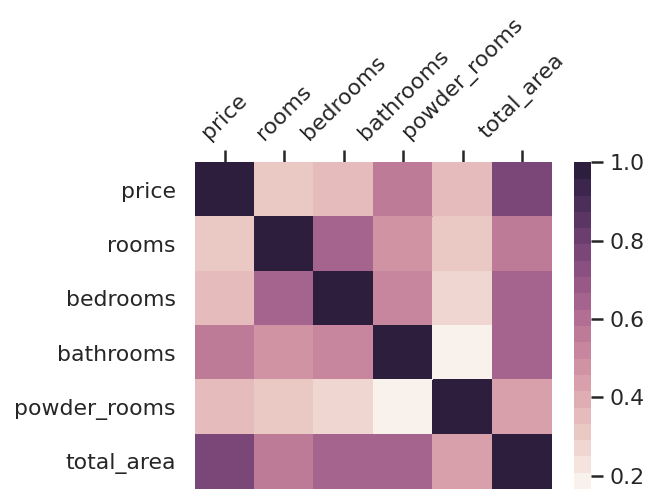

In [114]:
# Configure plot
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (4, 3) # size in inches 
plt.rcParams['axes.labelpad'] = 10
sns.set_style('darkgrid')

# Correlation heatmap
ax = sns.heatmap(rooms_and_price.corr(), cmap=sns.cubehelix_palette(20, light=0.95, dark=0.15))
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Save fig
plt.savefig('figures/total_area_corr_matrix.png', bbox_inches='tight', dpi=300)

From the heatmap we can see that `price` correlates best with `total_area`, followed by `bedrooms` and `bathrooms`.

In [117]:
# imports for regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
lin_mod_price = LinearRegression()
lin_mod_no_price = LinearRegression()

In [125]:
# Model including price
X = rooms_and_price.loc[:, : 'powder_rooms']
y = rooms_and_price["total_area"]
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y, test_size = 0.2, random_state=42)
# Fit model to training data 
lin_mod_price.fit(X_train_price, y_train_price)

# Model without price
X = rooms.loc[:, : 'powder_rooms']
y = rooms["total_area"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Fit model to training data 
lin_mod_no_price.fit(X_train, y_train)

LinearRegression()

In [141]:
# Predict test sample with price
pred_price = lin_mod_price.predict(X_test_price)
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_price, pred_price))
# R2
test_r2 = r2_score(y_test_price, pred_price)
print("Model with price:")
print("RMSE:", test_rmse)
print("R2:", test_r2)

# Predict test sample without price
pred = lin_mod_no_price.predict(X_test)
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, pred))
# R2
test_r2 = r2_score(y_test, pred)
print("\nModel without price:")
print("RMSE:", test_rmse)
print("R2:", test_r2)

Model with price:
RMSE: 300.9966499011587
R2: 0.7887043821912865

Model without price:
RMSE: 390.23910062458515
R2: 0.6448361702696629


In [ ]:
Including price gives a significant boost to the fit of the model, but the model without price still performs acceptably.

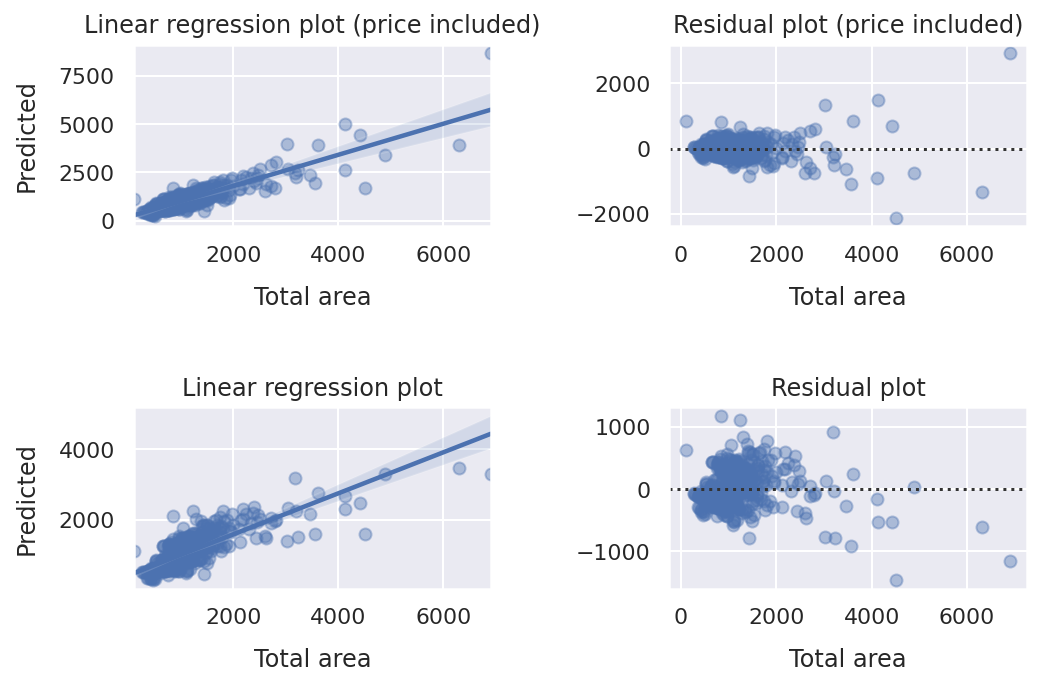

In [140]:
# Configure plot size
plt.rcParams['figure.figsize'] = (8, 5) # size in inches 
# Regression and residual plots
fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=1)
# Model with price data 
sns.regplot(y_test_price, pred_price, ax=ax[0, 0], scatter_kws={'alpha':0.4})
sns.residplot(y_test_price, pred_price, ax=ax[0, 1], scatter_kws={'alpha':0.4})
# Model without price data 
sns.regplot(y_test, pred, ax=ax[1, 0], scatter_kws={'alpha':0.4})
sns.residplot(y_test, pred, ax=ax[1, 1], scatter_kws={'alpha':0.4})
# Axis parameters
ax[0, 0].set(title='Linear regression plot (price included)', ylabel="Predicted", xlabel="Total area")
ax[0, 1].set(title='Residual plot (price included)', xlabel="Total area")
ax[1, 0].set(title='Linear regression plot', ylabel="Predicted", xlabel="Total area")
ax[1, 1].set(title='Residual plot', xlabel="Total area")
plt.savefig('figures/total_area_prediction.png', bbox_inches='tight', dpi=300)

The model is best suited for total areas below 4000 sqft but performs quite well in general. It seems unlikely that removing outliers will have a significant improvement on either model. Next we will replace 

In [144]:
replace_df = df[df.total_area < 50]
replace_df = replace_df.loc[:,\
        ['price', 'rooms',\
        'bedrooms','bathrooms',\
        'powder_rooms']\
            ]
replace_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 5 to 5318
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         2050 non-null   int64  
 1   rooms         2050 non-null   float64
 2   bedrooms      2050 non-null   float64
 3   bathrooms     2050 non-null   float64
 4   powder_rooms  2050 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 96.1 KB


In [66]:
replacement = lin_mod.predict(replace_df)

In [67]:
# Replace 
new_total_area = df.total_area.copy()
new_total_area[new_total_area < 50] = replacement
df["new_total_area"] = new_total_area

In [68]:
compair = df.loc[:, ["price", "new_total_area"]]
compair[df.total_area < 50]

,price,new_total_area
5,698000,574.586322
7,1725000,784.398274
8,619000,316.893612
9,679000,595.394096
10,569750,843.334937
...,...,...
5307,2399000,570.790451
5309,11900000,2964.948583
5311,1949000,757.763108
5312,3600000,953.667729


2050 values have been replace in `total_area`


In [69]:
compair.corr()

,price,new_total_area
price,1.000000,0.521415
new_total_area,0.521415,1.000000


In [70]:
 df[df.total_area < 50].loc[:, ['new_total_area', 'price']].corr()

,new_total_area,price
new_total_area,1.00000,0.70558
price,0.70558,1.00000


## River Proximity

In [71]:
# Columns with less than 3100 values
less_than_3100 = df.apply(lambda col: col.notnull().sum() < 3100, axis=0)
df.loc[:, less_than_3100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5319 entries, 0 to 5318
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   net_area                           2616 non-null   object
 1   pool                               1330 non-null   object
 2   additional_features                3026 non-null   object
 3   gross_area                         654 non-null    object
 4   building_style                     1963 non-null   object
 5   lot_area                           1696 non-null   object
 6   fireplace/stove                    783 non-null    object
 7   in_basement                        710 non-null    object
 8   use_of_property                    868 non-null    object
 9   number_of_units                    868 non-null    object
 10  residential_units                  833 non-null    object
 11  potential_gross_revenue            868 non-null    object
 12  interg

In [146]:
df.additional_features[df.additional_features.notnull()].value_counts()

Basement 6 feet or +                                                                   1238
Elevator                                                                                890
Adapted for reduced mobility, Elevator                                                  514
Located on a fleuve (river), Elevator                                                    36
Basement 6 feet or +, Elevator                                                           29
                                                                                       ... 
Access to a river, Navigable body of water, Adapted for reduced mobility, Elevator        1
Access to a river, Navigable body of water, Basement 6 feet or +                          1
Located on a canal, Access to a lake, Navigable body of water, Basement 6 feet or +       1
Furnished                                                                                 1
Access to a canal, Navigable body of water                                      

From this, the most valuable information might be proximity to river. We will check how many values correspond to this.

In [162]:
river_proximity = df.additional_features.apply(lambda x: re.search("[Rr]iver", str(x)))
river_proximity = pd.Series(river_proximity).astype("bool")
print("Listings with proximity to river:", river_proximity.sum())
# River proximity and price
river_and_price = pd.concat([river_proximity, df.price], axis=1)
print("\nRiver-price correlation all records:")
print(river_and_price.corr())

Listings with proximity to river: 187

River-price correlation all records:
                     additional_features     price
additional_features             1.000000  0.063159
price                           0.063159  1.000000


The data is too unbalanced with too little of a correlation with price to be useful in a linear regression. We will next create a balanced subset and reevaluate its correlation with price.

In [106]:
# Subset of records with river proximity
river_proximity = new[new.iloc[:,0] == True]
# Random records without river proximity of equal length to "river_proximity"
no_river_proximity = pd.DataFrame()
count = 0
index = 0
while count <= len(river_proximity):
    # New index to create random subset   
    index = random.choice(df.index)
    # Only elements neither in river_proximity nor no_river_proximity
    if index not in river_proximity.index\
        and index not in no_river_proximity.index:
        #Append
        no_river_proximity = no_river_proximity.append(\
            river_and_price.iloc[index, :])
        count += 1

mat = river_proximity.append(no_river_proximity)
print("\nRiver-price correlation with random 50:50 sub-set")
print(mat.corr())


River-price correlation with random 50:50 sub-set
              0     price
0      1.000000  0.218827
price  0.218827  1.000000


The correlation is still low but more interesting, we will keep the information as a seperate categorical feature for other potential models.